In [11]:
import numpy as np
from scipy import stats
from scipy import linalg
import pandas as pd
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from numpy.random import randn, uniform, multivariate_normal

import quandl

from helpers.stateEstimation import particleFilterSVmodel

sns.set_style()

from __future__ import division

## PMH for inference in the stochastic volatility model
Application of the particle Metropolois Hastings algorithm to infer the parameters of a stochastic volatility model as in: J. Dahlin and T. B. Schön, Getting started with particle Metropolis-Hastings for inference in nonlinear models. Pre-print, arXiv:1511:01707, 2017.. 

Consider the stochastic volatility model
$$
\begin{align}
x_0 &\sim \mathcal{N}\left(\mu,\frac{\sigma^2}{1-\phi^{2}}\right)\\
x_t\,|\,x_{t - 1} &\sim \mathcal{N}\left(\mu + \phi (x_{t - 1}-\mu),\,\sigma^2\right) \\
y_t\,|\,x_t &\sim \mathcal{N}\left(0,\,\exp(x_t)\right) \\
\end{align}
$$
with parameter vector $\theta = (\mu, \phi, \sigma)$.

### 1. Load data

The data consists of T=500 observations of the scaled log-returns from the NASDAQ OMX Stockholm 30 Index
during a two year period between January 2, 2012 and January 2, 2014.

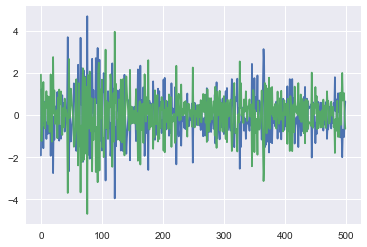

In [12]:
data = pd.read_csv('seOMXlogreturns2012to2014.csv', 
                   header=None, names=['logreturn'])
y = data.logreturn.values

data = quandl.get("NASDAQOMX/OMXS30", trim_start="2012-01-02", trim_end="2014-01-02")
logReturns = 100 * np.diff(np.log(data['Index Value']))
noLogReturns = len(logReturns)

fig, ax = plt.subplots()
ax.plot(y)
ax.plot(logReturns)

y = logReturns


### 2. Likelihood estimation with the bootstrap particle filter 


In [13]:
theta = [0.0,0.9,0.2]

def loglik_bpf(y, N, theta, resample=True, logweights=True):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    mu = theta[0]
    phi = theta[1]
    sigma = theta[2]
    
    samples = stats.norm.rvs(mu, np.power(sigma,2)/(1-np.power(phi,2)), N)
    weights = 1 / N * np.ones((N,))
    weights_normalized =  weights

    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        if resample:
            # Randomly choose ancestors
            ancestors = np.random.choice(samples, size=N, 
                                                     replace=True, p=weights_normalized)
        else:
            ancestors = samples
        
        # Propagate
        samples = mu+phi*(ancestors-mu)+stats.norm.rvs(0, 1, N)*sigma
        
        if logweights:
            # Weight
            weights = stats.norm.logpdf(y[t], loc=0, 
                                        scale=(np.exp(samples / 2)))
            # Calculate the max of the weights
            max_weights = np.max(weights)
            # Subtract the max
            weights = weights - max_weights
            # Update log-likelihood
            ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
        else:
            # Weight
            weights = stats.norm.pdf(y[t], loc=0, 
                                     scale=(np.exp(samples / 2)))
            # Update log-likelihood
            ll += np.log(np.sum(weights)) - np.log(N)

            # Normalize weights to be probabilities
            weights_normalized = weights / np.sum(weights)
        
    return ll

### 3. Particle Metropolis Hasting estimator

A Gaussian random walk proposal is used $q(\theta'\,\big|\,\theta[k - 1]) = \mathcal{N}\left(\theta';\,\theta[k - 1], \Sigma\right)$ with appropriately chosen $\Sigma$.

In [14]:
def particle_metropolis_hastings(y, theta_init, M, N, Sigma):
    
    # Allocate matrices
    theta = np.zeros((M+1,3))
    theta_prop = np.zeros((M,3))
    alpha = np.zeros((M,))
    alpha_accepted = np.zeros((M,))
    z = np.zeros((M+1,))
    
    # Initial state
    theta[0,:] = theta_init  
    z[0] = loglik_bpf(y,N,theta[0,:])
        
    # Iterate the chain
    t = tqdm_notebook(range(M))
    for i in t:
        # Sample a new value
        theta_prop[i,:] = theta[i,:]+np.random.multivariate_normal(mean=np.zeros(3),cov=Sigma)
      
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        
        # Acceptance probability    
        if ((np.abs(theta_prop[i,1]) < 1.0) & (theta_prop[i,2] > 0.0)):
            z_prop = loglik_bpf(y, N, theta_prop[i,:])
            (xHatFilteredProposed, z_prop) = particleFilterSVmodel(y, theta_prop[i, :],N)
            
            # Compute the ratio between the prior distributions (in log-form)
            prior = stats.norm.logpdf(theta_prop[i,0],0,1) 
            prior -= stats.norm.logpdf(theta[i,0],0,1)
            
            prior += stats.norm.logpdf(theta_prop[i,1],0.95,0.05) 
            prior -= stats.norm.logpdf(theta[i,1],0.95,0.05)

            prior += stats.gamma.logpdf(theta_prop[i,2],2,1.0/10.0) 
            prior -= stats.gamma.logpdf(theta[i,2],2,1.0/10.0)   
            
            # Compute the acceptance probability
            alpha[i] = np.min((1.0, np.exp(prior+z_prop-z[i])))
            alpha[i] *= np.abs(theta_prop[i,1]) < 1.0
            alpha[i] *= theta_prop[i,2] > 0.0
            
        # Set next state depending on acceptance probability
        if u <= alpha[i]:
            z[i+1] = z_prop
            theta[i+1,:] = theta_prop[i,:]
            alpha_accepted[i] = 1
        else:
            z[i+1] = z[i]
            theta[i+1,:] = theta[i,:]
            
        t.set_postfix({'a_mean': np.mean(alpha[:(i)]),'a_acc_mean':np.mean(alpha_accepted[:(i)])})
            
    return theta, alpha, theta_prop


In [29]:
M = 7500
burn_in = 2500
theta_init = [0.0,0.9,0.2]
Sigma = np.diag((0.10**2, 0.01**2, 0.05**2))
N = 500
theta, alpha, theta_prop = particle_metropolis_hastings(y,theta_init,M,N,Sigma)

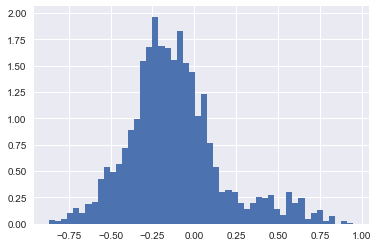

In [30]:
fig, ax = plt.subplots()
ax.hist(theta[burn_in:M,0], normed=True, bins=50);

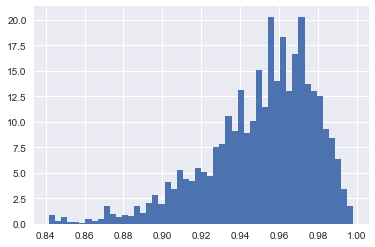

In [31]:
fig, ax = plt.subplots()
ax.hist(theta[burn_in:M,1], normed=True, bins=50);

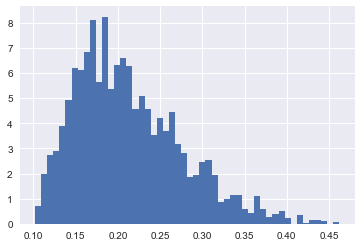

In [32]:
fig, ax = plt.subplots()
ax.hist(theta[burn_in:M,2], normed=True, bins=50);

array([ 0. ,  0.9,  0.2])

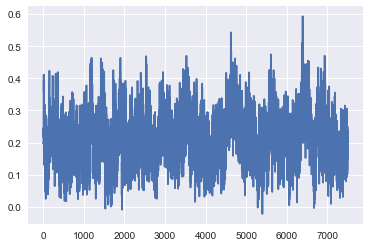

In [28]:
fig, ax = plt.subplots()
ax.plot(theta_prop[0:M,2]);
theta[0]